# Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import os
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

#### Path management

In [2]:
base: str
if os.getcwd() == "/kaggle/working":
    base = "/kaggle"
else:
    base = os.path.join(os.getcwd())

def get_full_dir(sub_dir: str) -> str:
    return os.path.join(base, sub_dir)

# EDA

In [3]:
df_sample_submission = pd.read_csv(get_full_dir('input/playground-series-s3e8/sample_submission.csv'))
df_train = pd.read_csv(get_full_dir('input/playground-series-s3e8/train.csv'), index_col='id')
df_test = pd.read_csv(get_full_dir('input/playground-series-s3e8/test.csv'), index_col='id')

In [4]:
df_train.isna().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
x          0
y          0
z          0
price      0
dtype: int64

##### Good we are not missing any data, we could lower dtype to save some memory (this data set is so small that is does not matter).

In [5]:
df_sample_submission.head()

,id,price
0,193573,3969.155
1,193574,3969.155
2,193575,3969.155
3,193576,3969.155
4,193577,3969.155


##### We are predicting prices of the gemstones based on their properties.

In [6]:
df_train.head()

,carat,cut,color,clarity,depth,table,x,y,z,price
id,,,,,,,,,,
0,1.52,Premium,F,VS2,62.2,58.0,7.27,7.33,4.55,13619
1,2.03,Very Good,J,SI2,62.0,58.0,8.06,8.12,5.05,13387
2,0.70,Ideal,G,VS1,61.2,57.0,5.69,5.73,3.50,2772
3,0.32,Ideal,G,VS1,61.6,56.0,4.38,4.41,2.71,666
4,1.70,Premium,G,VS2,62.6,59.0,7.65,7.61,4.77,14453


##### Cut, clarity and color are ordinal features (the features follow natural order) hence we will use OrdinalEncoder to convert them to numbers. From the original dataset we can find out the all the other feature are numerical and continuous depth, table, x, y and z are all measures of gem dimensions/key shape definitions. See data dictionary of the original data set for more information’s (https://www.kaggle.com/datasets/colearninglounge/gemstone-price-prediction).

In [7]:
for col in ['cut', 'color', 'clarity']:
    print(f'{col}: {df_train[col].unique()}')

cut: ['Premium' 'Very Good' 'Ideal' 'Good' 'Fair']
color: ['F' 'J' 'G' 'E' 'D' 'H' 'I']
clarity: ['VS2' 'SI2' 'VS1' 'SI1' 'IF' 'VVS2' 'VVS1' 'I1']


<text>We need to gather additional information’s to correctly encode these labels. Is 'ideal' better than 'very good'?</text>

<img src="https://ags2020.wpenginepowered.com/wp-content/uploads/2020/11/AGS%20Clarity%20Scale-2048x726.png">

<img src="https://ags2020.wpenginepowered.com/wp-content/uploads/2021/01/AGS%20Color%20Scale-2048x163.png">

<text>Source: https://www.americangemsociety.org/buying-diamonds-with-confidence/ags-diamond-grading-system/</text>

<test>We can also find out that colourless daimons are worth the most, and that 'ideal' is better than 'very good'. In addition, we have gained a very important insight in all three cut, color and clarity should be treated as continuous features hence be normalized.<text>

In [8]:
cut_map = {'Premium':0, 'Ideal':1, 'Very Good':2, 'Good':3, 'Fair':4}
color_map = {'F':1, 'G':1.5, 'J':3, 'E':0.5, 'D':0, 'H':2, 'I':2.5} # following the AGS scale for color
clarity_map = {'VS2':4, 'VS1':3, 'SI1':5, 'SI2': 6, 'IF':0, 'VVS1':1, 'VVS2':2, 'I1':8} # following the AGS scale for clarity

def encode_data(df):
    df['cut'] = df['cut'].map(cut_map)
    df['color'] = df['color'].map(color_map)
    df['clarity'] = df['clarity'].map(clarity_map)
    
encode_data(df_train)
encode_data(df_test) # we need to apply the same encoding to our test data as train

In [9]:
df_train.describe()

,carat,cut,color,clarity,depth,table,x,y,z,price
count,193573.000000,193573.000000,193573.000000,193573.000000,193573.000000,193573.000000,193573.000000,193573.000000,193573.000000,193573.000000
mean,0.790688,1.087631,1.258078,4.027561,61.820574,57.227675,5.715312,5.720094,3.534246,3969.155414
std,0.462688,0.882241,0.811545,1.507882,1.081704,1.918844,1.109422,1.102333,0.688922,4034.374138
min,0.200000,0.000000,0.000000,0.000000,52.100000,49.000000,0.000000,0.000000,0.000000,326.000000
25%,0.400000,0.000000,0.500000,3.000000,61.300000,56.000000,4.700000,4.710000,2.900000,951.000000
50%,0.700000,1.000000,1.500000,4.000000,61.900000,57.000000,5.700000,5.720000,3.530000,2401.000000
75%,1.030000,2.000000,2.000000,5.000000,62.400000,58.000000,6.510000,6.510000,4.030000,5408.000000
max,3.500000,4.000000,3.000000,8.000000,71.600000,79.000000,9.650000,10.010000,31.300000,18818.000000


<function matplotlib.pyplot.show(close=None, block=None)>

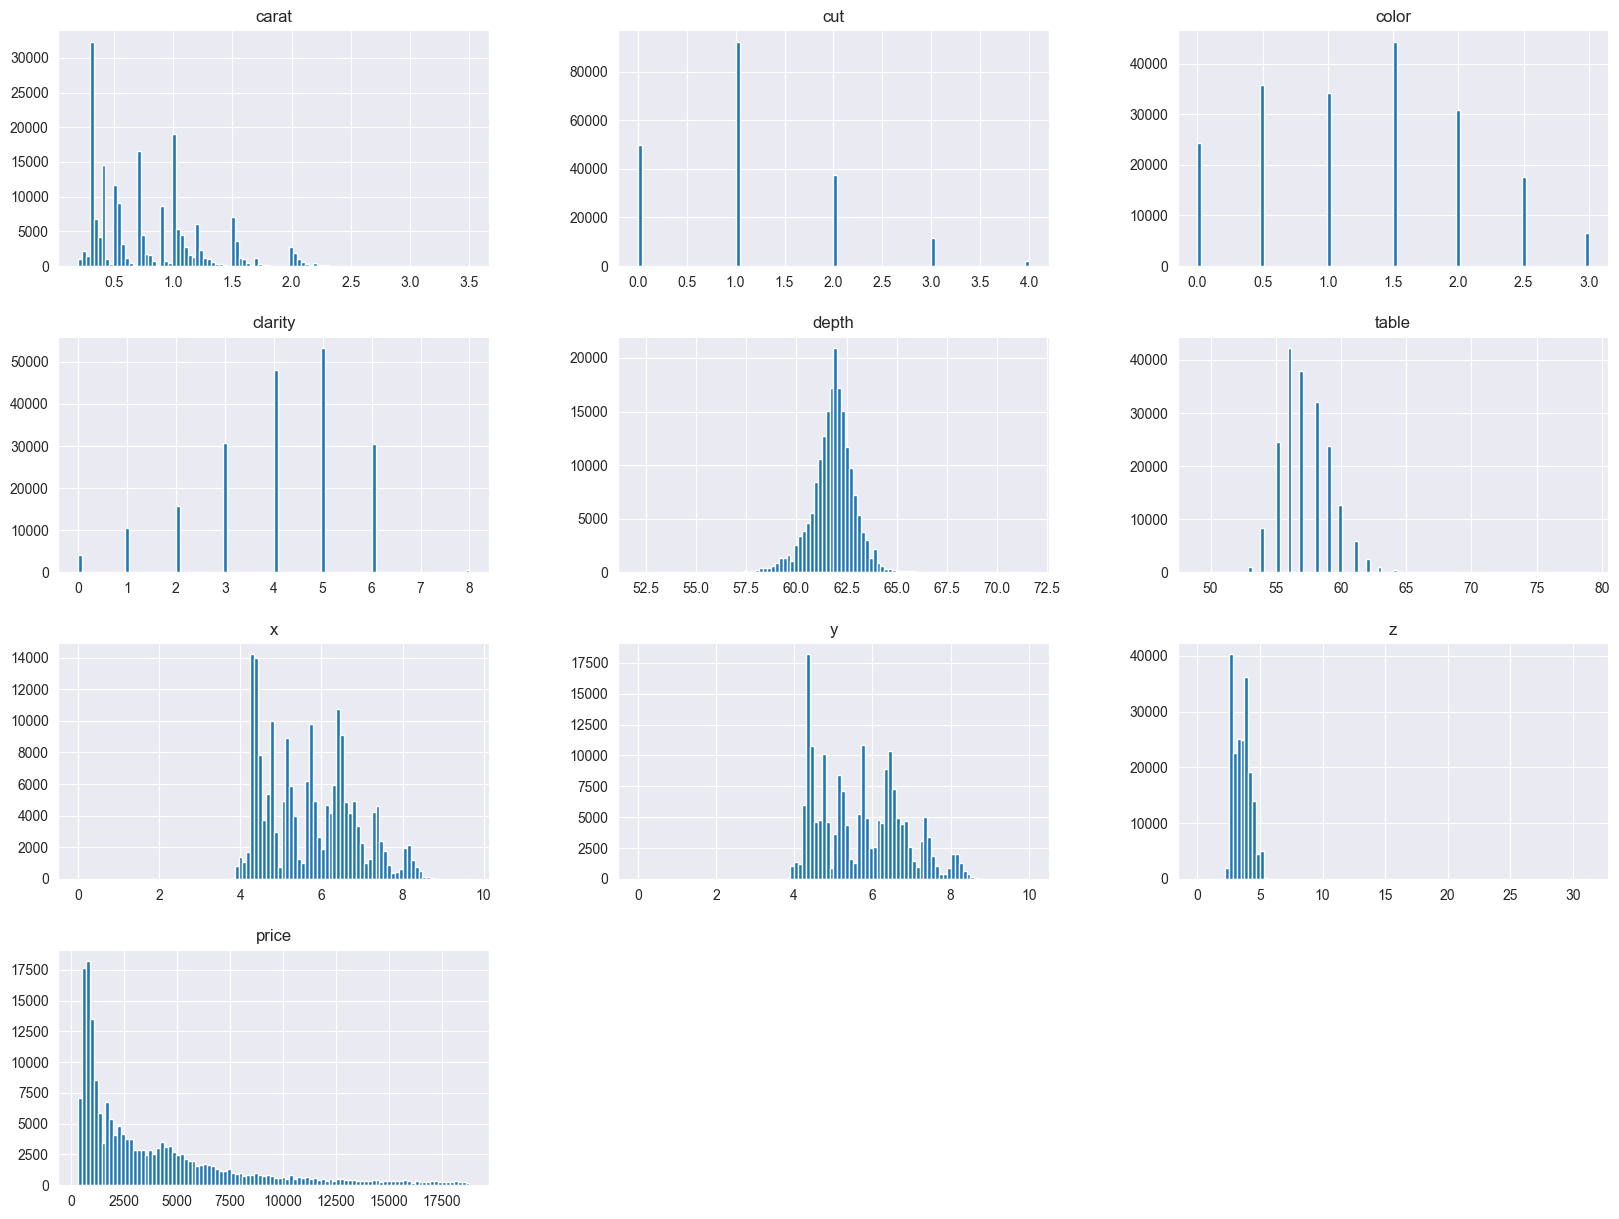

In [10]:
df_train.hist(bins=100, figsize=(20, 15))
plt.show

##### It appears that all features that have some outliers except for color, some of the outliers could be true outliers, gem of high quality (carat > 2.5) do exist in the population but are very rare hance expensive and would appear as outliers. For training purposes it may be beneficial to remove the outliers even if they are true outliers since they are representative of the underlying population.

In [11]:
def remove_outliers(df):
    # all numerical columns have some outliers, we will remove the 1st and 99th percetntile
    numerical_cols = df.select_dtypes(include='number').columns.tolist()
    for col in numerical_cols :
        if col not in ['color', 'cut', 'clarity']:
            first_percentile = df[col].quantile(0.01)
            ninety_ninth_percentile = df[col].quantile(0.99)
            df = df[df[col] > first_percentile]
            df = df[df[col] < ninety_ninth_percentile]
    return df

In [12]:
print(f'Dataset size with outliers: {len(df_train)}')            

# we need to make sure to revert df_train to its original from
# we dont want to remove outliers from out validation set 
# validation set would usually be separted at the beginign but we will be using KFolds
df_train = remove_outliers(df_train)

print(f'Dataset size without outliers: {len(df_train)}')

Dataset size with outliers: 193573
Dataset size without outliers: 157494


<function matplotlib.pyplot.show(close=None, block=None)>

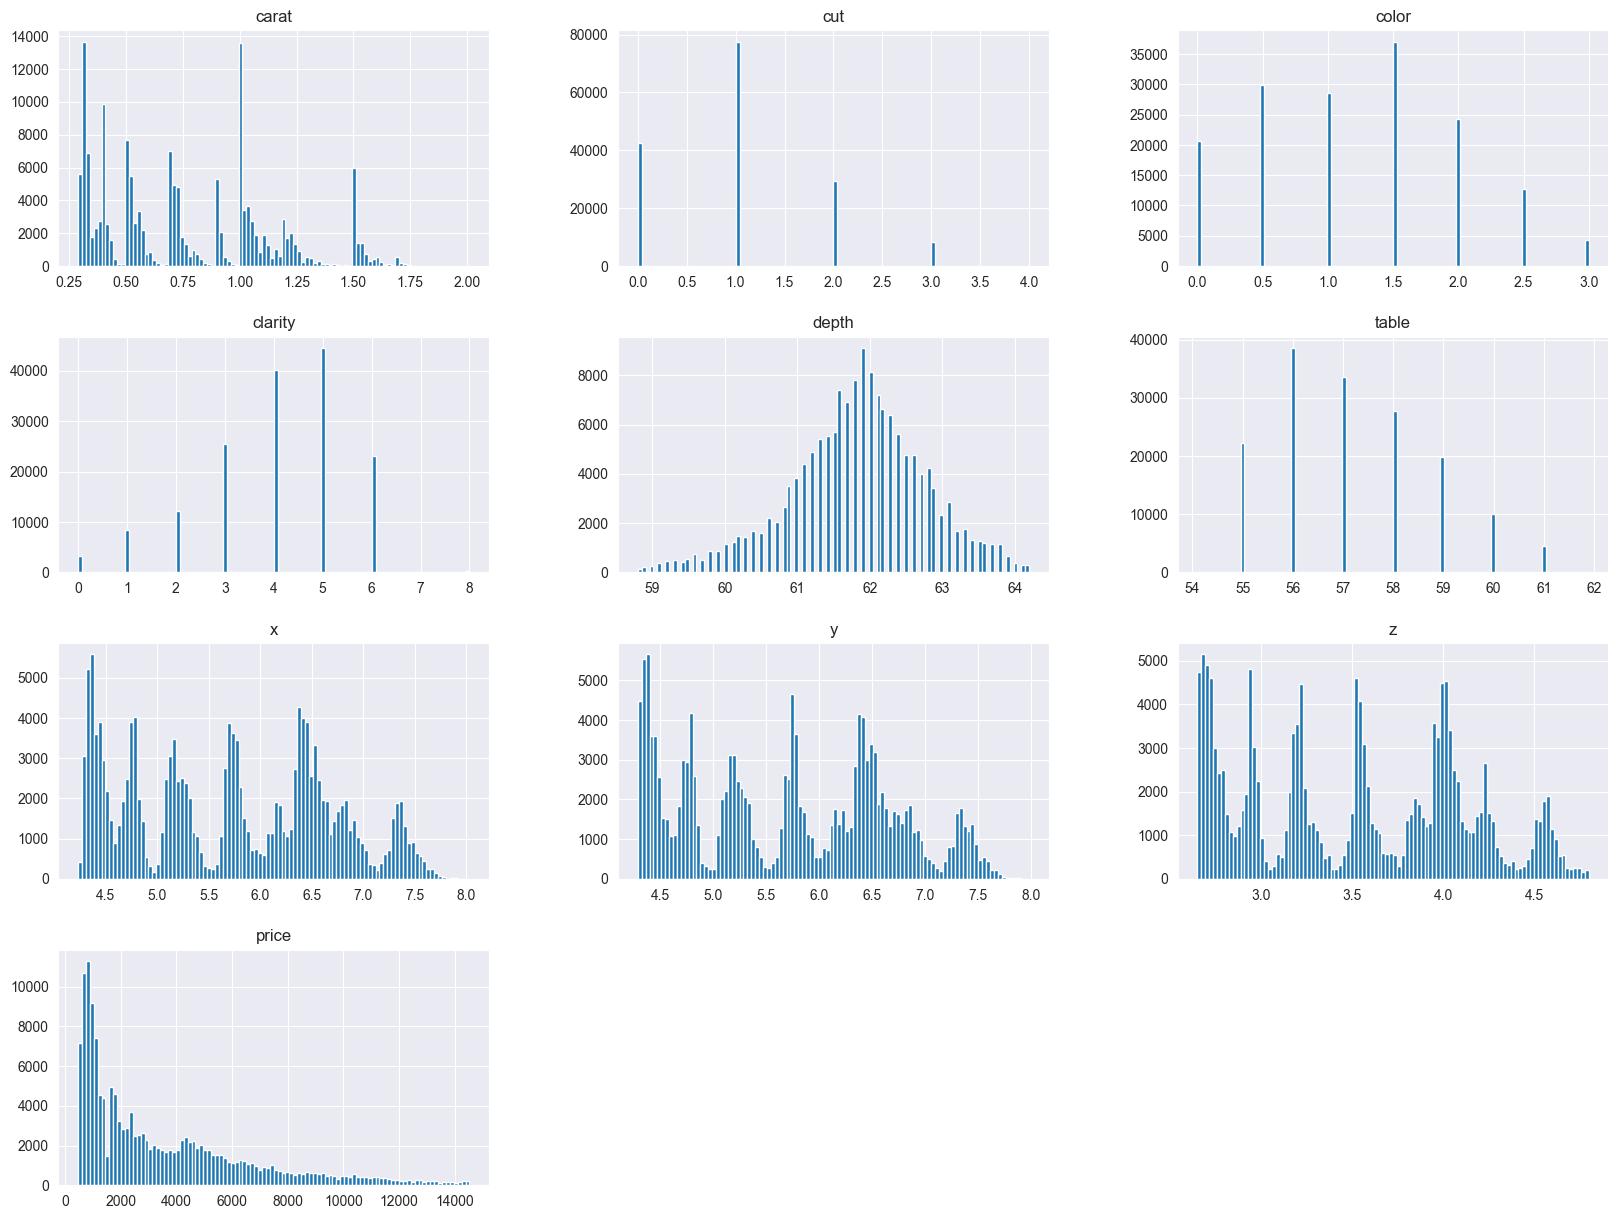

In [13]:
df_train.hist(bins=100, figsize=(20, 15))
plt.show

##### We have removed most outliers however have we have lost 18.6% of our training data, in the future we should revisit the method we used to remove outliers.

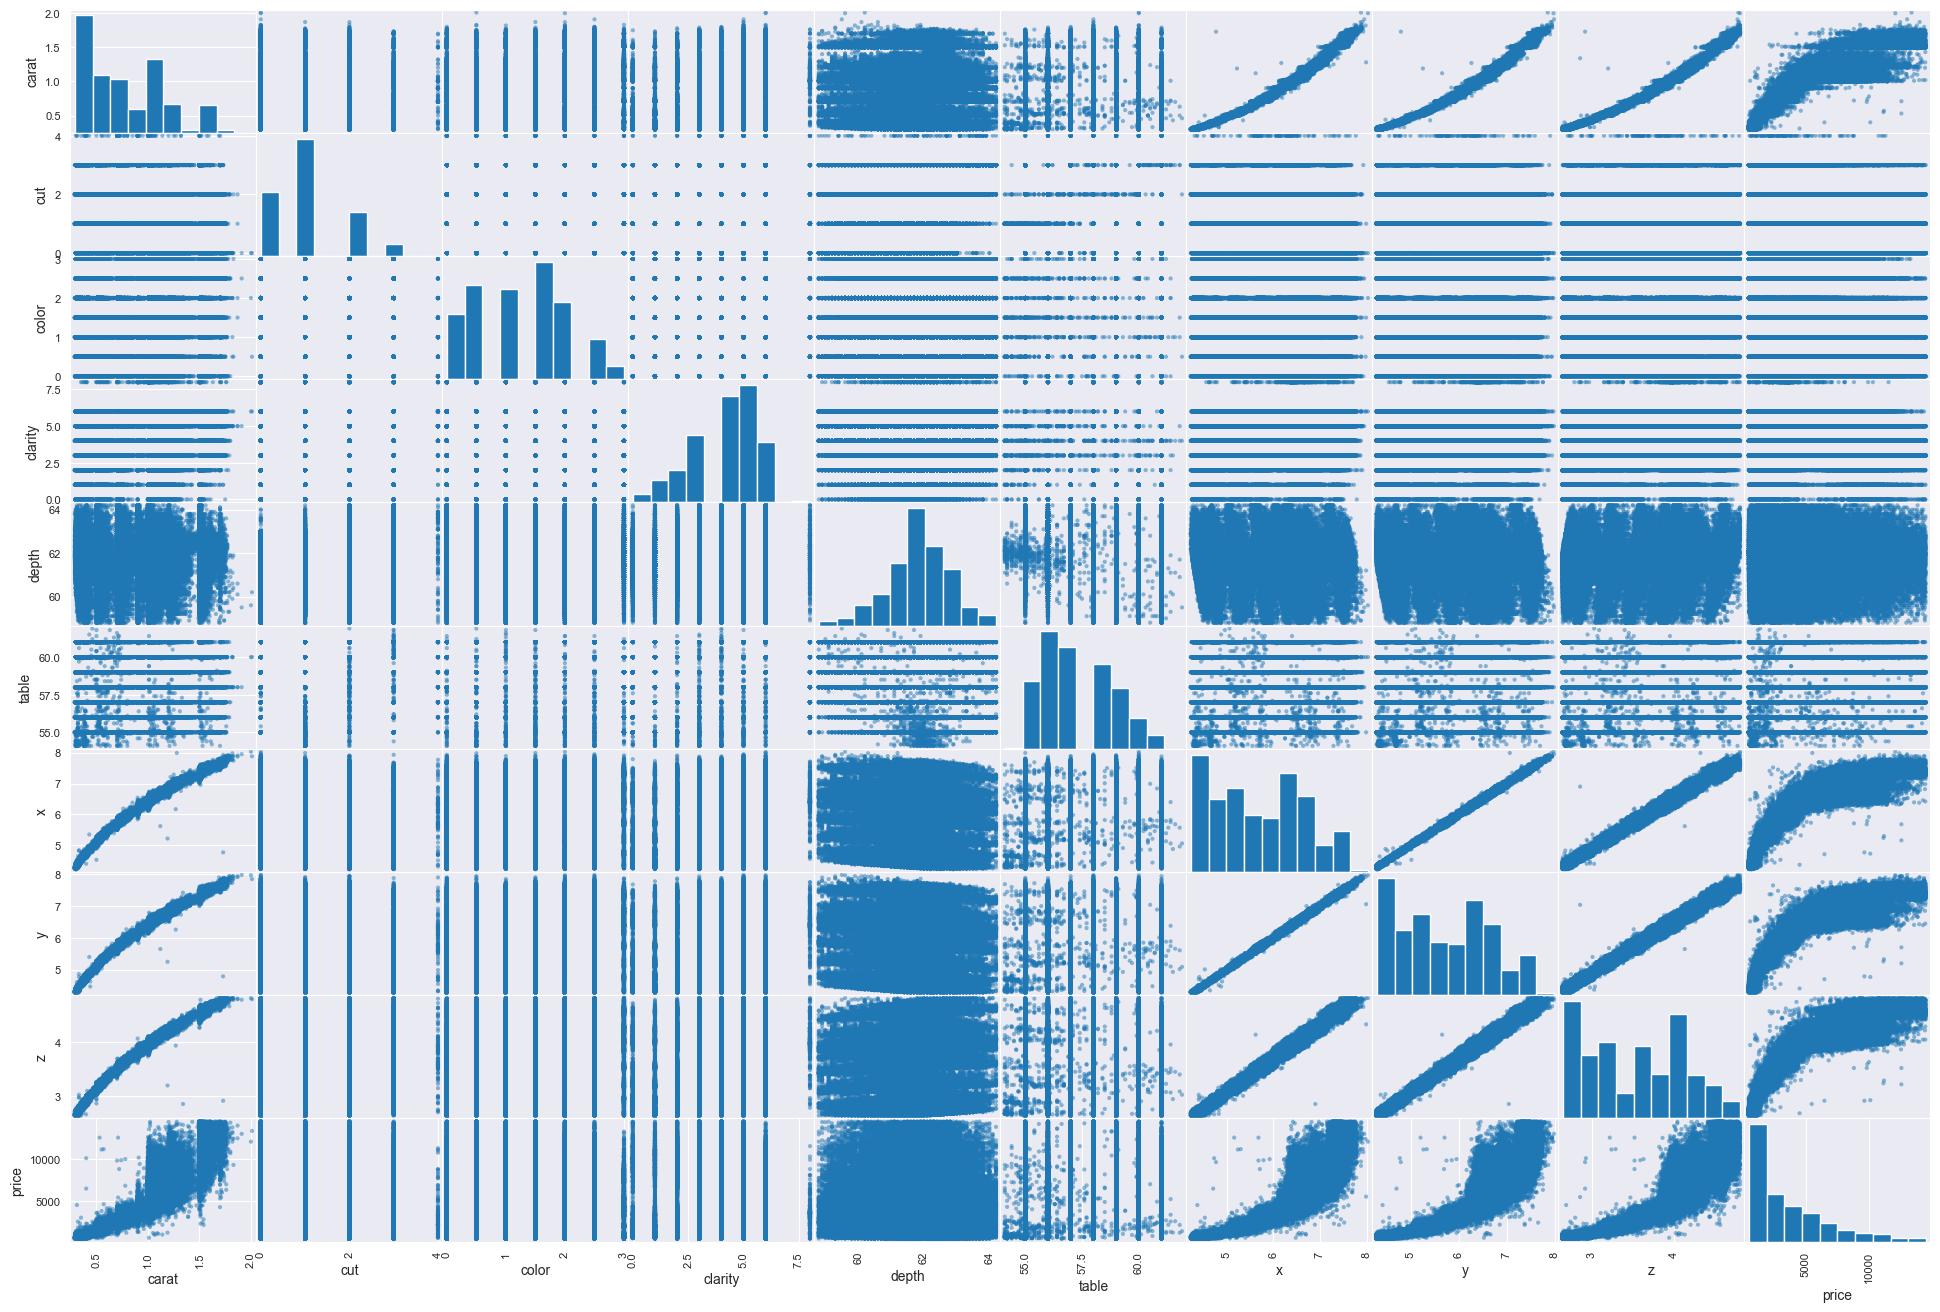

In [14]:
pd.plotting.scatter_matrix(df_train, figsize=(24, 16))
plt.savefig(r"figure_1.png")
plt.show()

##### You can download this figure to zoom in and view it in detail, but we will create to smaller views one looking at dimensions and other at properties.

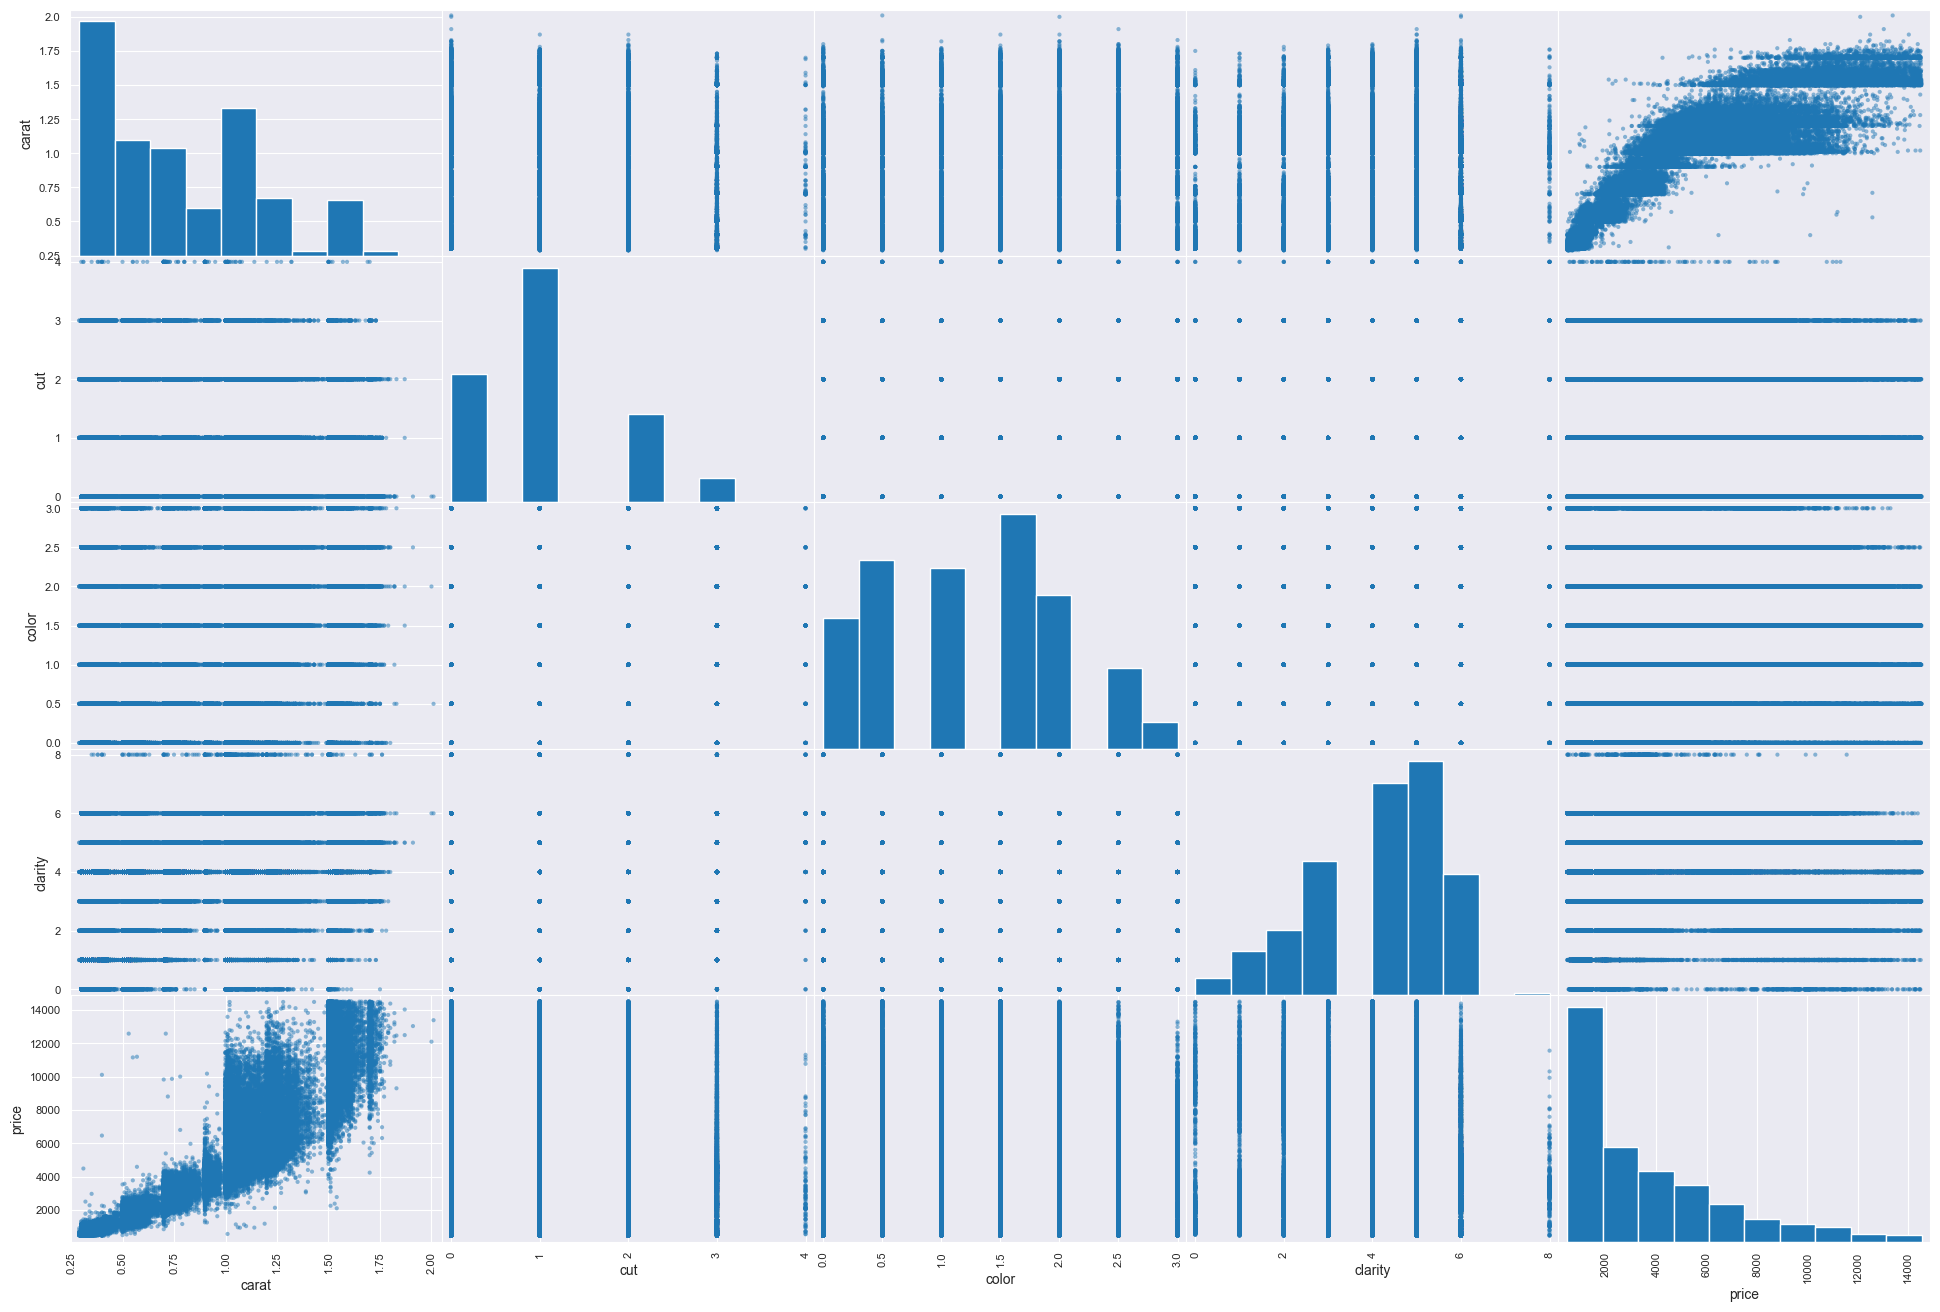

In [15]:
pd.plotting.scatter_matrix(df_train[['carat', 'cut', 'color', 'clarity', 'price']], figsize=(24, 16))
plt.savefig(r"figure_2.png")
plt.show()

##### It appears that carat has a weak positive corelation with our target while the rest could be noise.

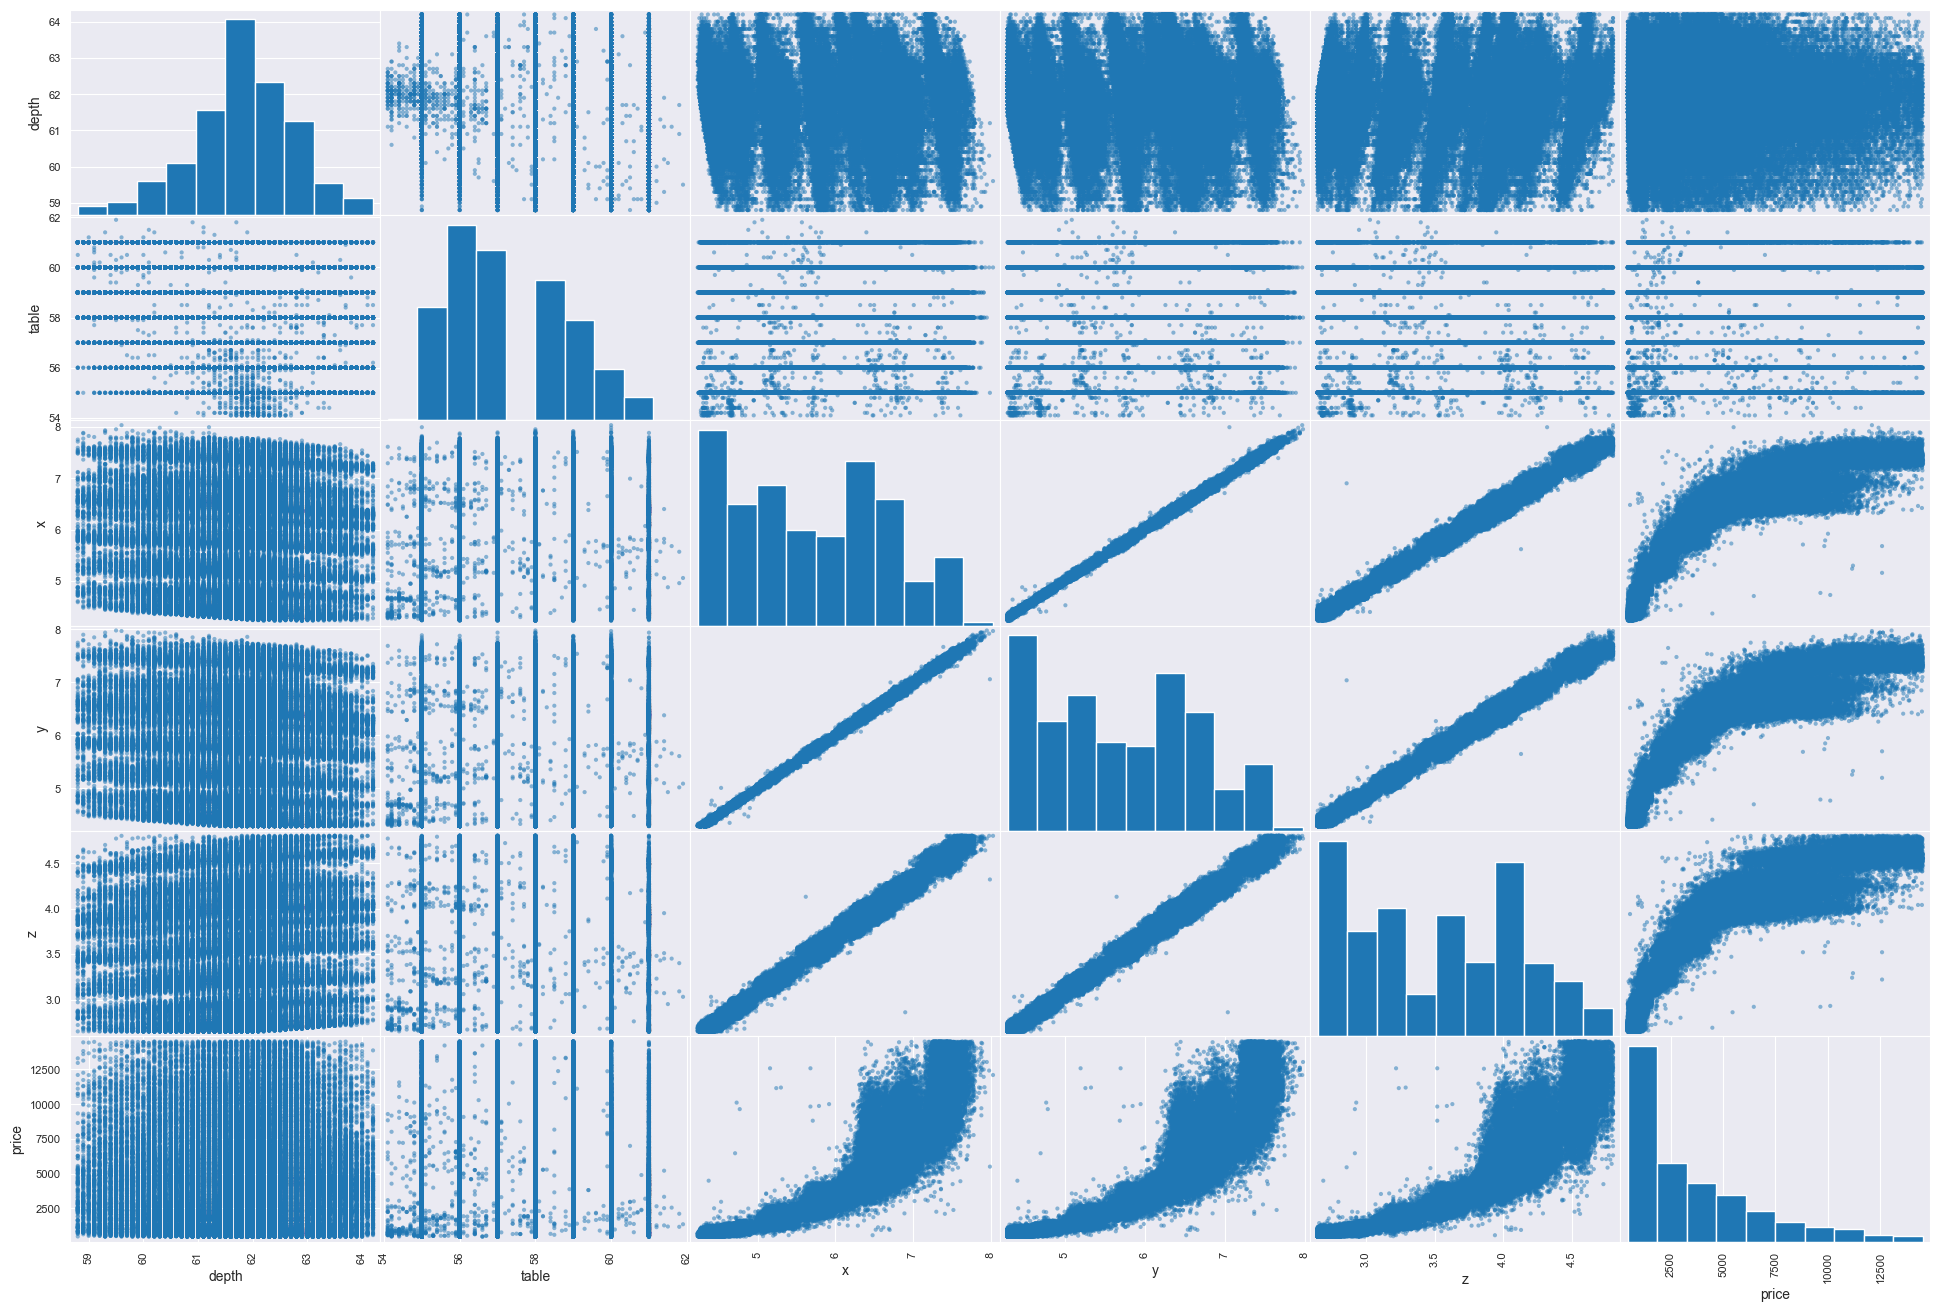

In [16]:
pd.plotting.scatter_matrix(df_train[['depth', 'table', 'x', 'y', 'z', 'price']], figsize=(24, 16))
plt.savefig(r"figure_3.png")
plt.show()

##### There are weak positive corelations between x, y, z and our target, table feature resembles spread of a categorical feature even thought it was originally continuous.

# Prep data from training

In [17]:
df_train = pd.read_csv(get_full_dir('input/playground-series-s3e8/train.csv'), index_col='id')
df_test = pd.read_csv(get_full_dir('input/playground-series-s3e8/test.csv'), index_col='id')
encode_data(df_train)
encode_data(df_test) # we need to apply the same encoding to our test data as train

#df_train = df_train.drop(['cut', 'color', 'clarity'], axis=1)
#df_test = df_test.drop(['cut', 'color', 'clarity'], axis=1)

# Data Pipeline

In [18]:
class GemPipeline():
    
    def __init__(self):
        self.preprocessor = ColumnTransformer([ 
            ("num", StandardScaler(), df_train.drop('price', axis=1).columns.tolist()), 
        ])
        self.model = xgb.XGBRegressor(n_estimators = 1000, 
                                      learning_rate = 0.01, 
                                      max_depth = 7, 
                                      colsample_bytree = 0.7, 
                                      objective='reg:squarederror',
                                      gamma = 0.8, 
                                      min_child_weight = 10, 
                                      subsample = 0.7
                                     )
        self.target_preprocessor = StandardScaler()
    
    def _add_features(self, X):
        pass
        
    def fit(self, X, y, X_eval, y_eval):
        self._add_features(X)
        self._add_features(X_eval)
        
        X = self.preprocessor.fit_transform(X)
        X_val = self.preprocessor.transform(X_eval)
        
        y = self.target_preprocessor.fit_transform(y.to_numpy().reshape(-1, 1))
        y_val = self.target_preprocessor.transform(y_eval.to_numpy().reshape(-1, 1))
        
        self.model.fit(X, y, eval_set=[(X_val, y_val)], verbose=False)
        
    def predict(self, X):
        self._add_features(X)
        X = self.preprocessor.transform(X)
        y_pred = self.model.predict(X)
        y_pred = self.target_preprocessor.inverse_transform(y_pred.reshape(-1, 1))
        return y_pred
    
    def grid_search(self, X, y, X_eval, y_eval):
        # Processes the data
        X = self.preprocessor.fit_transform(X)
        X_val = self.preprocessor.transform(X_eval)
    
        y = self.target_preprocessor.fit_transform(y.to_numpy().reshape(-1, 1))
        y_val = self.target_preprocessor.transform(y_eval.to_numpy().reshape(-1, 1))
        
        # Define the hyperparameters and their possible values
        param_grid = {
            'n_estimators': [10, 100, 1000],
            'max_depth': [3, 7, 11],
            'learning_rate':[0.1, 0.2], 
            'subsample': [1, 10],
            'reg_lambda': [0, 1, 2],
            'reg_alpha': [0, 1, 2],
            'objective':['reg:squarederror'],
            'early_stopping_rounds':[5],
            'tree_method':["gpu_hist"]
        }

        # Create an XGBoost model and wrap it in a GridSearchCV object
        xgb_model = xgb.XGBRegressor()
        grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5)

        # Train the GridSearchCV object with early stopping
        grid_search.fit(X, y_train, eval_set=[(X_val, y_val)], verbose=False)
        
        print(grid_search.best_params_)


# Hyperparamiter search

In [19]:
#X = df_train.drop('price', axis=1)
#y = df_train['price']
#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)
#CustomePipeline().grid_search(X_train, y_train, X_val, y_val)

# Train the model

In [20]:
X = df_train.drop(['price'], axis=1)
y = df_train['price']
SKFs = KFold(n_splits=5, shuffle=True, random_state=1)
losses = []
pipelines = []
for fold, (idx_tr, idx_vl) in enumerate(SKFs.split(X, y)):
    # splits data to dev/train sets and removes outliers from train data
    train_dataframe = df_train.iloc[idx_tr]
    # it appears that removing outliers drasticly hurt the models accrecy,
    # i will have the review the this topic
    #train_dataframe = remove_outliers(train_dataframe)
    dev_dataframe = df_train.iloc[idx_vl]
    
    # splits data to features and target
    X_train = train_dataframe.drop('price', axis=1)
    y_train = train_dataframe['price']
    X_dev = dev_dataframe.drop('price', axis=1)
    y_dev = dev_dataframe['price']
    
    # crates and fits a pipeline
    pipelineMy = GemPipeline()
    pipelineMy.fit(X_train, y_train, X_dev, y_dev)
    
    # evaluates the model
    pipelines.append(pipelineMy)
    loss = mean_squared_error(y_dev, pipelineMy.predict(X_dev), squared=False)
    losses.append(loss)
    print(f'Fold {fold} loss: {loss}')
print(f'Mean loss: {np.array(losses).mean()}')

Fold 0 loss: 566.639879947132
Fold 1 loss: 556.3319715409912
Fold 2 loss: 580.0099130486083
Fold 3 loss: 580.748173734511
Fold 4 loss: 581.4799452645888
Mean loss: 573.0419767071663


# Feature Importance 

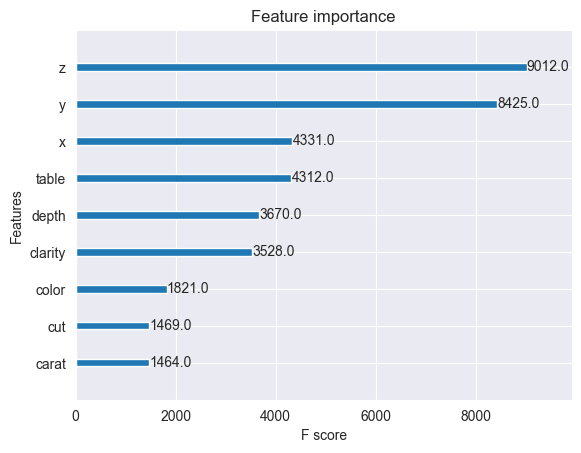

In [21]:
booster = pipelines[0].model.get_booster()
importance_scores = booster.get_score(importance_type='weight')

# Plot feature importance
fig, ax = plt.subplots()
xgb.plot_importance(booster, importance_type='weight', ax=ax)
ax.set_yticklabels(X.columns)
plt.show()

##### All features appear to be useful, some more than others. Color, cut and clarity initially looked like they had no correlation with our target while carat did, is our model overfitting to cut color and clarity ? 

# Make Submission

In [22]:
def make_predictions(pipelines, data):
    prediction = []
    for pipeline in pipelines:
        prediction.append(pipeline.predict(data))
    return np.array(prediction).mean(axis = 0).ravel()

In [23]:
finale_predictions = make_predictions(pipelines, df_test)

In [24]:
submissions = pd.DataFrame({"id": list(range(193573, 193573 + len(finale_predictions))), "price": finale_predictions})

In [25]:
pd.DataFrame(submissions).to_csv("submission.csv", index=False, header=True)